In [1]:
import numpy as np

In [2]:
import heron
import heron.models.georgebased

In [3]:
generator = heron.models.georgebased.HeronHodlr()

In [4]:
times = np.linspace(-0.02, 0.05, 1000)

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
stimes = np.linspace(-0.05, 0.01, 70)
hp, hx = generator.bilby(stimes, 65, 22, 1000).values()

In [7]:
%%timeit
hp, hx = generator.bilby(stimes, 65, 22, 1000).values()

193 ms ± 280 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


/home/daniel/.virtualenvs/aries/heron-stable/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ["'URW Bookman L'"] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


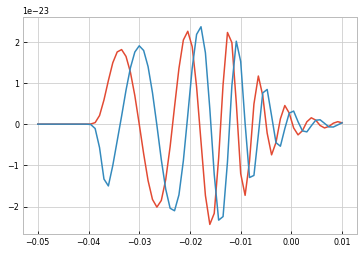

In [8]:
plt.plot(stimes, hp)
plt.plot(stimes, hx)

In [9]:
import bilby

14:18 bilby INFO    : Running bilby version: 0.5.8: (UNCLEAN) 0995d176 2019-09-27 12:34:18 +0100
14:18 bilby WARNING : You do not have gwpy installed currently. You will  not be able to use some of the prebuilt functions.
14:18 bilby WARNING : You do not have gwpy installed currently. You will  not be able to use some of the prebuilt functions.
14:18 bilby WARNING : You do not have gwpy installed currently. You will  not be able to use some of the prebuilt functions.


In [10]:
from astropy import constants as c
def heronbilby(time, mass_1, mass_2, luminosity_distance):
        """
        Return a waveform from the GPR in a format expected by the Bilby ecosystem
        """

        times_b = time.copy()
        #times_b -= generator.t_min
        
        mass_ratio = mass_1 / mass_2
        total_mass_cat = generator.total_mass
        time_factor_cat = (c.c.value**3 / c.G.value)/(total_mass_cat*c.M_sun.value) #*1e4
        #h_factor = c.pc.value
        
        total_mass = mass_1 + mass_2 #bilby.gw.conversion.chirp_mass_and_mass_ratio_to_total_mass(chirp_mass, mass_ratio)
                
    
        time_factor = (c.c.value**3 / c.G.value)/(total_mass*c.M_sun.value) 
    
        times_b *= (total_mass_cat / total_mass) #(time_factor/time_factor_cat)

        p = {'mass ratio': 1,
            'spin 1x': 0,  'spin 1y': 0,  'spin 1z': 0,
            'spin 2x': 0,  'spin 2y': 0,  'spin 2z': 0}

        p['mass ratio'] = mass_ratio
        
        mean = generator.mean(p=p, times = times_b)
    
        return {"plus": mean[0].data / luminosity_distance , "cross": mean[1].data / luminosity_distance}

In [11]:
duration = 0.06
sampling_frequency = 1000
waveform = bilby.gw.waveform_generator.WaveformGenerator(
    duration=duration, sampling_frequency=sampling_frequency,
    time_domain_source_model=generator.bilby,
    start_time=-0.05)

In [12]:
# inject the signal into three interferometers
ifos = bilby.gw.detector.InterferometerList(['L1'])
ifos.set_strain_data_from_power_spectral_densities(
    sampling_frequency=sampling_frequency, duration=duration,
    start_time=0)

/scratch/aries/daniel/repositories/bilby/bilby/gw/detector/psd.py:356: RuntimeWarning: invalid value encountered in multiply
  frequency_domain_strain = self.__power_spectral_density_interpolated(frequencies) ** 0.5 * white_noise


In [13]:
injection_parameters = {"mass_1": 30, "mass_2": 30, "luminosity_distance": 1000, "geocent_time": 0, "ra": 10, "dec": 0, "psi": 0}
ifos.inject_signal(waveform_generator=waveform,
                   parameters=injection_parameters);

14:18 bilby INFO    : Injected signal in L1:
14:18 bilby INFO    :   optimal SNR = 25.88
14:18 bilby INFO    :   matched filter SNR = 26.09-0.75j
14:18 bilby INFO    :   mass_1 = 30
14:18 bilby INFO    :   mass_2 = 30
14:18 bilby INFO    :   luminosity_distance = 1000
14:18 bilby INFO    :   geocent_time = 0
14:18 bilby INFO    :   ra = 10
14:18 bilby INFO    :   dec = 0
14:18 bilby INFO    :   psi = 0


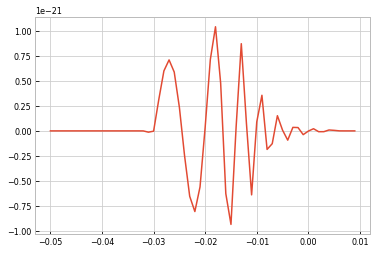

In [18]:
plt.plot(waveform.time_array, waveform.time_domain_strain()['plus'])

In [19]:
priors = bilby.gw.prior.BBHPriorDict()

14:19 bilby INFO    : No prior given, using default BBH priors in /scratch/aries/daniel/repositories/bilby/bilby/gw/prior_files/binary_black_holes.prior.


In [20]:
outdir="test_heron-2"
label="pe-test"

priors['geocent_time'] = bilby.core.prior.Uniform(
    minimum=injection_parameters['geocent_time'] - 1,
    maximum=injection_parameters['geocent_time'] + 1,
    name='geocent_time', latex_label='$t_c$', unit='$s$')

for key in priors.keys():
    if not key in injection_parameters:
        priors[key] = 0
del(priors['mass_ratio'])
# Initialise the likelihood by passing in the interferometer data (ifos) and
# the waveform generator
likelihood = bilby.gw.GravitationalWaveTransient(
    interferometers=ifos, waveform_generator=waveform)

14:20 bilby WARNING : The waveform_generator start_time is not equal to that of the provided interferometers. Overwriting the waveform_generator.


In [ ]:
# Run sampler.  In this case we're going to use the `dynesty` sampler
result = bilby.run_sampler(
    likelihood=likelihood, priors=priors, sampler='dynesty', npoints=1000,
    outdir=outdir, label=label, injection_parameters=injection_parameters)

14:20 bilby INFO    : Running for label 'pe-test', output will be saved to 'test_heron-2'
14:20 bilby INFO    : Using LAL version Branch: None;Tag: lalsuite-v6.62;Id: a75e6c243c5695e1abdcc4e5d91f623cf0db1d22;;Builder: Unknown User <>;Repository status: UNCLEAN: Modified working tree
14:20 bilby INFO    : Search parameters:
14:20 bilby INFO    :   mass_1 = Uniform(minimum=5, maximum=100, name='mass_1', latex_label='$m_1$', unit='$M_{\\odot}$', boundary=None)
14:20 bilby INFO    :   mass_2 = Uniform(minimum=5, maximum=100, name='mass_2', latex_label='$m_2$', unit='$M_{\\odot}$', boundary=None)
14:20 bilby INFO    :   luminosity_distance = UniformSourceFrame(minimum=100.0, maximum=5000.0, cosmology=FlatLambdaCDM(name="Planck15", H0=67.7 km / (Mpc s), Om0=0.307, Tcmb0=2.725 K, Neff=3.05, m_nu=[0.   0.   0.06] eV, Ob0=0.0486), name='luminosity_distance', latex_label='$d_L$', unit=Unit("Mpc"), boundary=None)
14:20 bilby INFO    :   dec = Cosine(name='dec', latex_label='$\\mathrm{DEC}$', unit

 1998| logz ratio=43.267 +/-  1.381 | dlogz:  1.098 >  0.100

14:47 bilby INFO    : Writing checkpoint file test_heron-2/pe-test_resume.pickle
/home/daniel/.virtualenvs/aries/heron-stable/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ["'URW Bookman L'"] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


 2009| logz ratio=-0.330 +/-  0.024 | dlogz: 51.188 >  0.100

/scratch/aries/daniel/repositories/bilby/bilby/gw/likelihood.py:189: RuntimeWarning: invalid value encountered in cdouble_scalars
  complex_matched_filter_snr = d_inner_h / (optimal_snr_squared**0.5)


 2018| logz ratio=-0.326 +/-  0.024 | dlogz: 51.176 >  0.100

/scratch/aries/daniel/repositories/bilby/bilby/gw/likelihood.py:189: RuntimeWarning: divide by zero encountered in cdouble_scalars
  complex_matched_filter_snr = d_inner_h / (optimal_snr_squared**0.5)


 2826| logz ratio=49.615 +/-  0.497 | dlogz:  0.873 >  0.100

15:21 bilby INFO    : Writing checkpoint file test_heron-2/pe-test_resume.pickle
/home/daniel/.virtualenvs/aries/heron-stable/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ["'URW Bookman L'"] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


 2828| logz ratio= 0.035 +/-  0.029 | dlogz: 56.821 >  0.100

/scratch/aries/daniel/repositories/bilby/bilby/gw/likelihood.py:189: RuntimeWarning: invalid value encountered in cdouble_scalars
  complex_matched_filter_snr = d_inner_h / (optimal_snr_squared**0.5)


 2832| logz ratio= 0.038 +/-  0.030 | dlogz: 56.814 >  0.100

/scratch/aries/daniel/repositories/bilby/bilby/gw/likelihood.py:189: RuntimeWarning: divide by zero encountered in cdouble_scalars
  complex_matched_filter_snr = d_inner_h / (optimal_snr_squared**0.5)


 3391| logz ratio=59.774 +/-  1.014 | dlogz:  1.073 >  0.100

16:06 bilby INFO    : Writing checkpoint file test_heron-2/pe-test_resume.pickle
/home/daniel/.virtualenvs/aries/heron-stable/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ["'URW Bookman L'"] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/scratch/aries/daniel/repositories/bilby/bilby/gw/likelihood.py:189: RuntimeWarning: invalid value encountered in cdouble_scalars
  complex_matched_filter_snr = d_inner_h / (optimal_snr_squared**0.5)
/scratch/aries/daniel/repositories/bilby/bilby/gw/likelihood.py:189: RuntimeWarning: divide by zero encountered in cdouble_scalars
  complex_matched_filter_snr = d_inner_h / (optimal_snr_squared**0.5)


 3769| logz ratio=59.396 +/-  1.126 | dlogz:  1.073 >  0.100

16:59 bilby INFO    : Writing checkpoint file test_heron-2/pe-test_resume.pickle
/home/daniel/.virtualenvs/aries/heron-stable/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ["'URW Bookman L'"] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


 4027| logz ratio=59.138 +/-  1.137 | dlogz:  1.073 >  0.100

17:59 bilby INFO    : Writing checkpoint file test_heron-2/pe-test_resume.pickle
/home/daniel/.virtualenvs/aries/heron-stable/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ["'URW Bookman L'"] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


 4328| logz ratio=84.626 +/-  0.965 | dlogz:  1.099 >  0.100

19:09 bilby INFO    : Writing checkpoint file test_heron-2/pe-test_resume.pickle
/home/daniel/.virtualenvs/aries/heron-stable/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ["'URW Bookman L'"] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


 4671| logz ratio=103.192 +/-  0.863 | dlogz:  1.098 >  0.100

20:29 bilby INFO    : Writing checkpoint file test_heron-2/pe-test_resume.pickle
/home/daniel/.virtualenvs/aries/heron-stable/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ["'URW Bookman L'"] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


 5057| logz ratio=120.486 +/-  0.724 | dlogz:  1.094 >  0.100

22:01 bilby INFO    : Writing checkpoint file test_heron-2/pe-test_resume.pickle
/home/daniel/.virtualenvs/aries/heron-stable/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ["'URW Bookman L'"] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


 5486| logz ratio=120.057 +/-  0.751 | dlogz:  1.094 >  0.100

23:42 bilby INFO    : Writing checkpoint file test_heron-2/pe-test_resume.pickle
/home/daniel/.virtualenvs/aries/heron-stable/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ["'URW Bookman L'"] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


 5957| logz ratio=119.586 +/-  0.958 | dlogz:  1.094 >  0.100

01:31 bilby INFO    : Writing checkpoint file test_heron-2/pe-test_resume.pickle
/home/daniel/.virtualenvs/aries/heron-stable/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ["'URW Bookman L'"] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


 6472| logz ratio=119.071 +/-  0.983 | dlogz:  1.094 >  0.100

03:31 bilby INFO    : Writing checkpoint file test_heron-2/pe-test_resume.pickle
/home/daniel/.virtualenvs/aries/heron-stable/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ["'URW Bookman L'"] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


 7030| logz ratio=121.669 +/-  0.648 | dlogz:  1.040 >  0.100

05:39 bilby INFO    : Writing checkpoint file test_heron-2/pe-test_resume.pickle
/home/daniel/.virtualenvs/aries/heron-stable/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ["'URW Bookman L'"] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


 7631| logz ratio=123.281 +/-  0.535 | dlogz:  0.948 >  0.100

07:56 bilby INFO    : Writing checkpoint file test_heron-2/pe-test_resume.pickle
/home/daniel/.virtualenvs/aries/heron-stable/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ["'URW Bookman L'"] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


 7833| logz ratio=33.371 +/-  0.135 | dlogz: 97.087 >  0.100

findfont: Font family ["'URW Bookman L'"] not found. Falling back to DejaVu Sans.


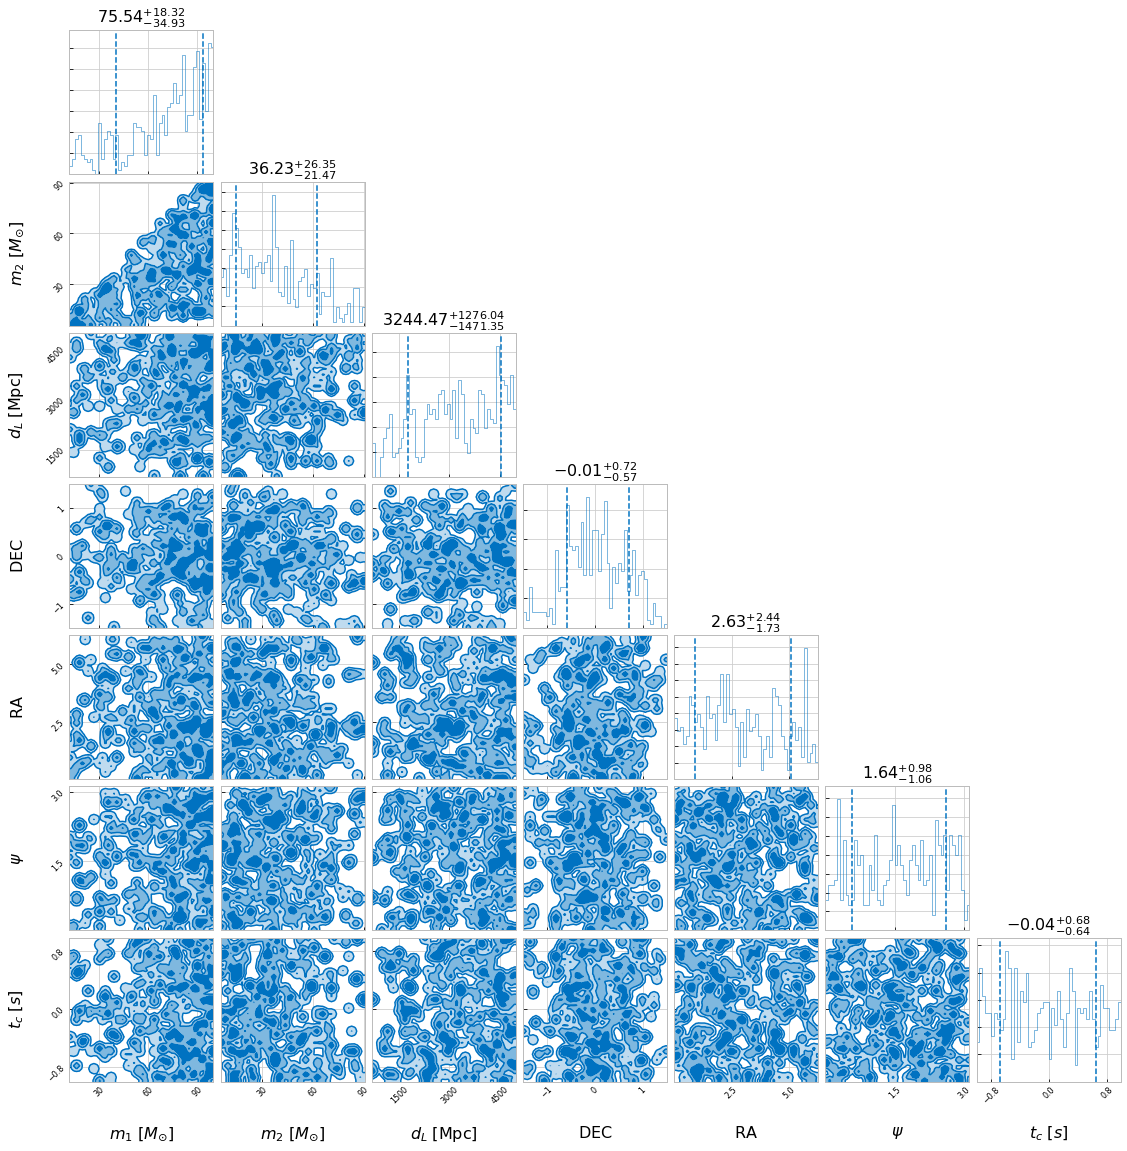

In [41]:
# Make a corner plot.
result.plot_corner()